In [1]:
from numba import vectorize
import numpy as np
from numba import cuda

ufuncs/gufuncs (subject of this section)

###### Universal Functions

NumPy has the concept of universal functions ("ufuncs"), which are functions that can take NumPy arrays of varying dimensions (or scalars) and operate on them element-by-element.

It is probably easiest to show what happens by example. We'll use the NumPy add ufunc to demonstrate what happens:

In [26]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b)

array([11, 22, 33, 44])

Ufuncs also can combine scalars with arrays:m

In [27]:
np.add(a, 100)

array([101, 102, 103, 104])

Arrays of different, but compatible dimensions can also be combined. The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array

In [21]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)
print('b:', b )
np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
b: [10. 20. 30. 40.]


array([[10., 21., 32., 43.],
       [14., 25., 36., 47.],
       [18., 29., 40., 51.],
       [22., 33., 44., 55.]])

In the above situation, the b array is added to each row of c. If we want to add b to each column, we need to transpose it. There are several ways to do this, but one way is to insert a new axis using np.newaxis:

In [38]:
b_col = b[:, np.newaxis]
b_col.astype(dtype='int32')

array([[10],
       [20],
       [30],
       [40]])

In [39]:
np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

###### Making ufuncs for the GPU

Numba has the ability to create compiled ufuncs. You implement a scalar function of all the inputs, and Numba will figure out the broadcast rules for you. Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the target attribute:

In [44]:
from numba import vectorize

@vectorize(['int32(int32, int32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [46]:
print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


A lot of things just happened! Numba automatically:

    - Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
    - Allocated GPU memory for the inputs and the output.
    - Copied the input data to the GPU.
    - Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
    - Copied the result back from the GPU to the CPU.
    - Returned the result as a NumPy array on the host.

This is very convenient for testing, but copying data back and forth between the CPU and GPU can be slow and hurt performance. In the next tutorial notebook, you'll learn about device management and memory allocation.

You might be wondering how fast our simple example is on the GPU? Let's see:

In [48]:
%timeit np.add(b_col, c)   # NumPy on CPU

1.56 µs ± 41.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [49]:
%timeit add_ufunc(b_col, c) # Numba on GPU

1.19 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wow, the GPU is a lot slower than the CPU?? This is to be expected because we have (deliberately) misused the GPU in several ways in this example:
- Our inputs are too small: the GPU achieves performance through parallelism, operating on thousands of values at once. Our test inputs have only 4 and 16 integers, respectively. We need a much larger array to even keep the GPU busy.
- Our calculation is too simple: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU. If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
- We copy the data to and from the GPU: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
- Our data types are larger than necessary: Our example uses int64 when we probably don't need it. Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU. Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. NumPy defaults to 64-bit data types when creating arrays, so it is important to set the dtype attribute or use the ndarray.astype() method to pick 32-bit types when you need them.


Given the above, let's try an example that is faster on the GPU:

In [50]:
import math  # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [53]:
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test
gaussian_pdf(x[0], 0.0, 1.0)

array([0.00466425], dtype=float32)

In [54]:
import scipy.stats # for definition of gaussian distribution
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

89.3 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit gaussian_pdf(x, mean, sigma)

11.9 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU. Ufuncs that use special functions (exp, sin, cos, etc) on large data sets run especially well on the GPU.

##### Simple function

In [10]:
@vectorize(['float32(float32, float32)'], target='cuda') # ???
def add_ufunc(x, y):
    return x + y

In [11]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [3]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

4.67 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
y.shape

(100000,)

##### Device

In [10]:
len(cuda.gpus)

1

In [11]:
cuda.gpus[0].name

b'GeForce GTX 1050 Ti'

The numba.cuda module includes a function that will copy host data to the GPU and return a CUDA device array:

In [12]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [14]:
%timeit add_ufunc(x_device, y_device) # it is faster corresponding to the first case

2.17 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create the output buffer with the numba.cuda.device_array() function:

In [16]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

In [17]:
%timeit add_ufunc(x_device, y_device, out=out_device)

1.87 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now that we have removed the device allocation and copy steps, the computation runs much faster than before. When we want to bring the device array back to the host memory, we can use the copy_to_host() method

In [18]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


##### Exercise

In [19]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

In [21]:
pulses = make_pulses(t, period, 100.0)

In [23]:
len(pulses)
len(noise)

100000

In [24]:
waveform = add_ufunc(pulses, noise) # It uses GPU

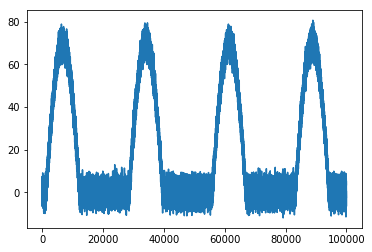

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

###### Cuda Kernels

In [24]:
@cuda.jit
def add_kernel(x, y, out):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size
    
    print(tx.copy_to_host()) # How to print?
    
    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

Also note that we did not need to specify a type signature for the CUDA kernel. Unlike @vectorize, Numba can infer the type signature from the inputs automatically, and much more reliably

In [25]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

TypingError: Failed at nopython (nopython frontend)
[1m[1mUnknown attribute 'copy_to_host' of type int32
[1m
File "<ipython-input-24-8de81d0bd0a0>", line 12:[0m
[1mdef add_kernel(x, y, out):
    <source elided>
    
[1m    print(tx.copy_to_host()) # How to print?
[0m    [1m^[0m[0m
[0m
[0m[1m[1] During: typing of get attribute at <ipython-input-24-8de81d0bd0a0> (12)[0m
[1m
File "<ipython-input-24-8de81d0bd0a0>", line 12:[0m
[1mdef add_kernel(x, y, out):
    <source elided>
    
[1m    print(tx.copy_to_host()) # How to print?
[0m    [1m^[0m[0m


Note that, unlike the ufunc, the arguments are passed to the kernel as full NumPy arrays. The kernel can access any element in the array it wants, regardless of its position in the thread grid. This is why CUDA kernels are significantly more powerful that ufuncs. (But with great power, comes a greater amount of typing..

In [21]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # 1 = one dimensional thread grid, returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]